# Stock Forecasting using Pastas (Model Diagnostic Checking)

https://pastas.readthedocs.io/en/latest/index.html  
https://github.com/pastas/pastas  

In [1]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pastas as ps
from scipy import stats

import yfinance as yf
yf.pdr_override()

In [2]:
ps.set_log_level("ERROR")
ps.show_versions(numba=True)

Python version: 3.6.13 |Anaconda, Inc.| (default, Mar 16 2021, 11:37:27) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.19.5
Scipy version: 1.5.4
Pandas version: 1.1.5
Pastas version: 0.18.0
Matplotlib version: 3.3.4
numba version: 0.38.0


In [3]:
stock = 'AMD' # input
start = '2020-01-01' # input 
end = '2021-11-23'  # input
df = yf.download(stock, start, end)

[*********************100%***********************]  1 of 1 completed


In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,46.860001,49.250000,46.630001,49.099998,49.099998,80331100
2020-01-03,48.029999,49.389999,47.540001,48.599998,48.599998,73127400
2020-01-06,48.020000,48.860001,47.860001,48.389999,48.389999,47934900
2020-01-07,49.349998,49.389999,48.040001,48.250000,48.250000,58061400
2020-01-08,47.849998,48.299999,47.139999,47.830002,47.830002,53767000


In [5]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-16,145.929993,153.080002,145.339996,152.449997,152.449997,53100800
2021-11-17,151.979996,154.660004,149.690002,151.339996,151.339996,54527500
2021-11-18,157.070007,158.889999,152.559998,155.020004,155.020004,60612700
2021-11-19,155.759995,156.919998,153.449997,155.410004,155.410004,41633400
2021-11-22,157.139999,161.880005,152.389999,152.520004,152.520004,58674100


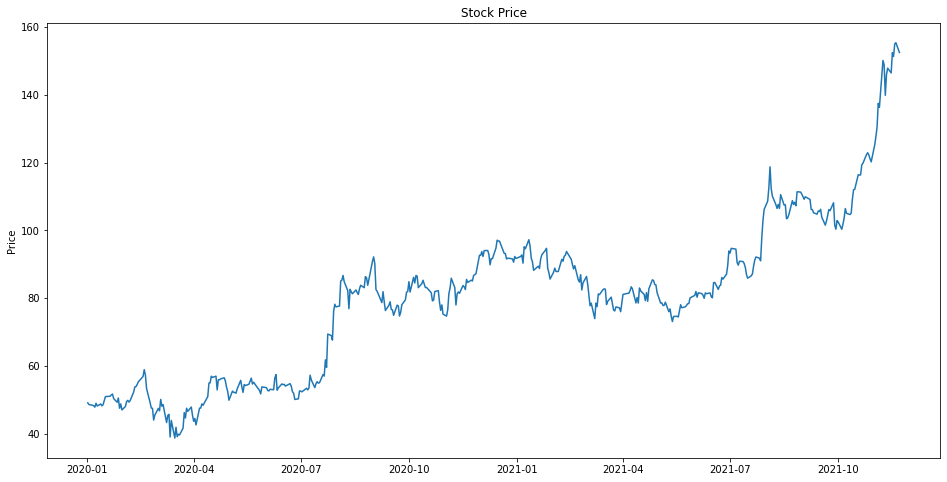

In [6]:
plt.figure(figsize=(16,8))
plt.plot(df['Adj Close'])
plt.title('Stock Price')
plt.ylabel('Price')
plt.show()

In [7]:
df['Middle'] = df['High'] - df['Low']

In [8]:
df['Returns'] = df['Adj Close'].pct_change()

In [9]:
df = df.rename(columns={'Adj Close':'AdjClose'})

In [10]:
df = df.dropna()

In [11]:
df.head()

,Open,High,Low,Close,AdjClose,Volume,Middle,Returns
Date,,,,,,,,
2020-01-03,48.029999,49.389999,47.540001,48.599998,48.599998,73127400,1.849998,-0.010183
2020-01-06,48.020000,48.860001,47.860001,48.389999,48.389999,47934900,1.000000,-0.004321
2020-01-07,49.349998,49.389999,48.040001,48.250000,48.250000,58061400,1.349998,-0.002893
2020-01-08,47.849998,48.299999,47.139999,47.830002,47.830002,53767000,1.160000,-0.008705
2020-01-09,48.939999,49.959999,48.389999,48.970001,48.970001,76512800,1.570000,0.023834


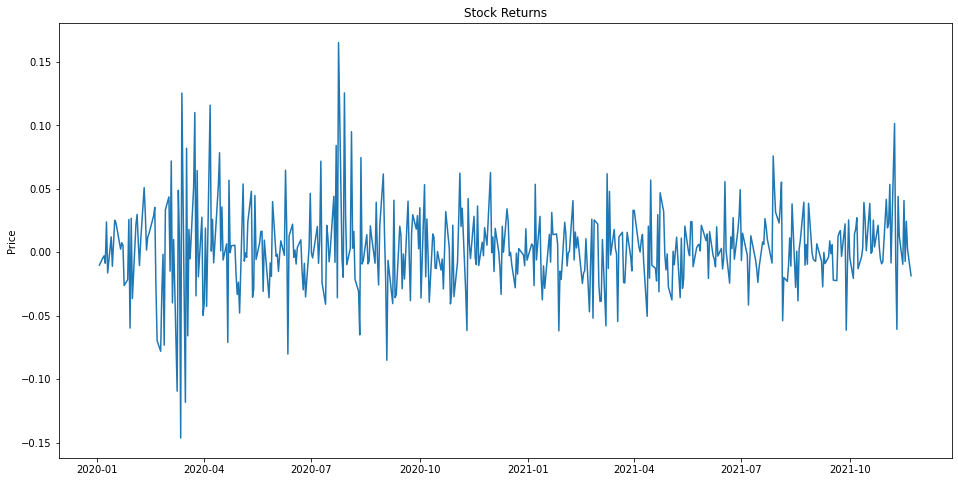

In [12]:
plt.figure(figsize=(16,8))
plt.plot(df['Returns'])
plt.title('Stock Returns')
plt.ylabel('Price')
plt.show()

In [13]:
df.columns.values

array(['Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume', 'Middle',
       'Returns'], dtype=object)

In [14]:
dfr = df['Returns'].resample('D').mean().interpolate('linear')
dfv = df['Volume'].resample('D').mean().interpolate('linear')
dfh = df['High'].resample('D').mean().interpolate('linear')
dfl = df['Low'].resample('D').mean().interpolate('linear')
df2 = df['AdjClose'].resample('D').mean().interpolate('linear')

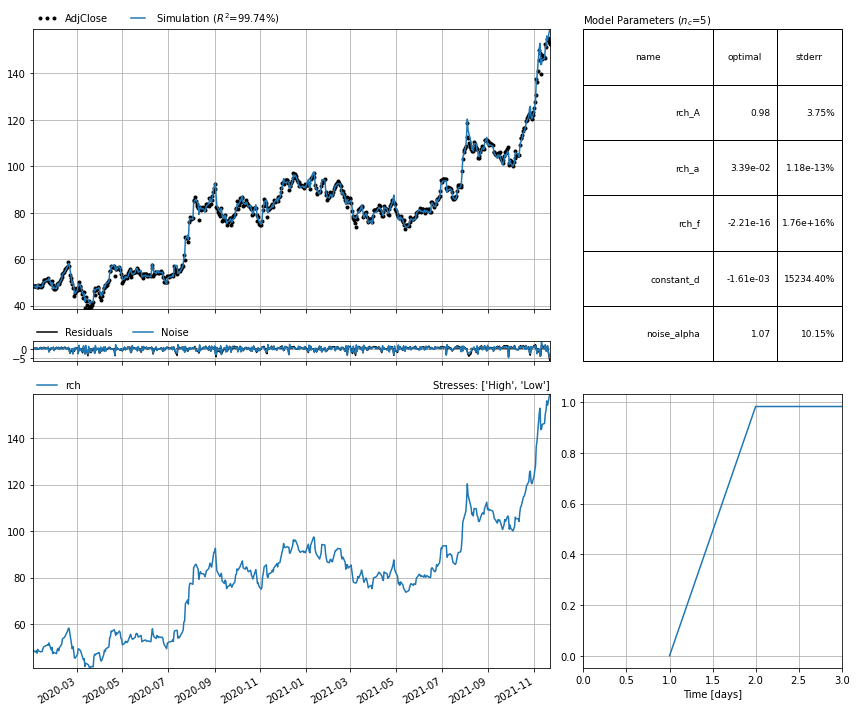

In [15]:
ml = ps.Model(df2)
sm = ps.RechargeModel(dfh, dfl, rfunc=ps.Exponential, name="rch")
ml.add_stressmodel(sm)
ml.solve(report=False)
axes = ml.plots.results(figsize=(12,10))

[<AxesSubplot:title={'center':'Noise (n=690, $\\mu$=-0.00)'}, ylabel='Noise'>,
 <AxesSubplot:title={'center':'Autocorrelation plot'}, xlabel='Lag [Days]', ylabel='Autocorrelation [-]'>,
 <AxesSubplot:title={'center':'Histogram'}, ylabel='Probability density'>,
 <AxesSubplot:title={'center':'Probability Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered Values'>]

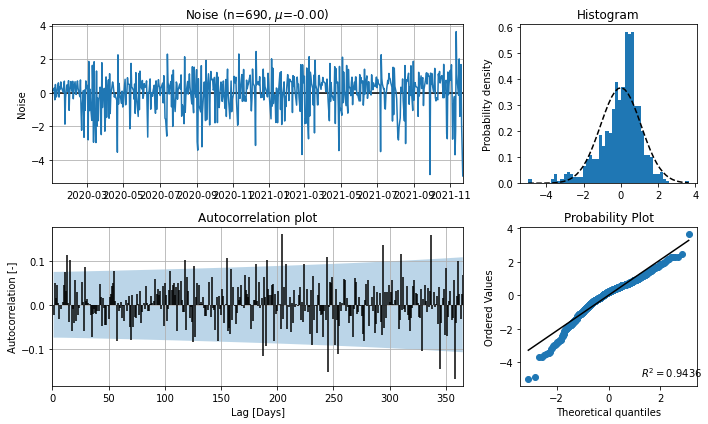

In [16]:
alpha = 0.05

ml.plots.diagnostics()

In [17]:
ml.stats.diagnostics(alpha=0.05)



,Checks,Statistic,P-value,Reject H0
Shapiroo,Normality,0.95,0.00,True
D'Agostino,Normality,115.29,0.00,True
Runs test,Autocorr.,-4.65,0.00,True
Ljung-Box,Autocorr.,39.30,0.00,True
Durbin-Watson,Autocorr.,1.65,nan,False


In [18]:
time_steps = df['Returns'].resample('D').mean().interpolate('linear')

<AxesSubplot:xlabel='Date'>

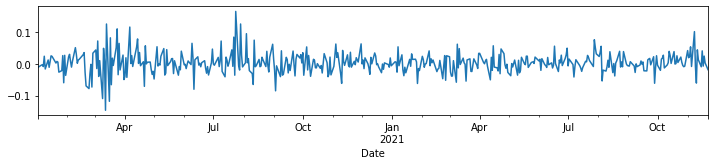

In [19]:

noise = pd.Series(time_steps)
noise.plot(figsize=(12,2))

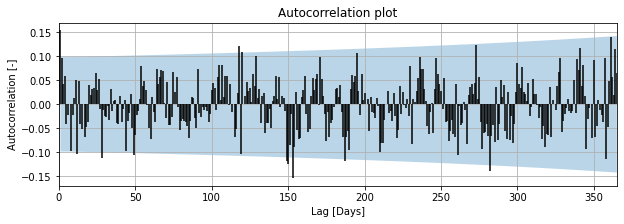

In [20]:
ax = ps.stats.plot_acf(noise, acf_options=dict(bin_width=0.5), figsize=(10,3), alpha=0.01)

In [21]:
stat, p = ps.stats.ljung_box(noise, lags=15)

if p > alpha:
    print("Failed to reject the Null-hypothesis, no significant autocorrelation. p =", p.round(2))
else:
    print("Reject the Null-hypothesis. p =", p.round(2))

Reject the Null-hypothesis. p = 0.0


In [22]:
dw_stat = ps.stats.durbin_watson(noise)

print(dw_stat)

(1.6917745231232564, nan)


In [23]:
stat, p = ps.stats.stoffer_toloi(noise, lags=15, freq="D")

if p > alpha:
    print("Failed to reject the Null-hypothesis, no significant autocorrelation. p =", p.round(2))
else:
    print("Reject the Null-hypothesis")

Reject the Null-hypothesis


In [24]:
stat, p = ps.stats.runs_test(noise)

if p > alpha:
    print("Failed to reject the Null-hypothesis, no significant autocorrelation. p =", p.round(2))
else:
    print("Reject the Null-hypothesis")

Reject the Null-hypothesis


In [25]:
stat, p = stats.shapiro(noise)

if p > alpha:
    print("Failed to reject the Null-hypothesis, residuals may come from Normal distribution. p =", np.round(p, 2))
else:
    print("Reject the Null-hypothesisp =", np.round(p, 2))



Reject the Null-hypothesisp = 0.0


In [26]:
stat, p = stats.normaltest(noise)

if p > alpha:
    print("Failed to reject the Null-hypothesis, residuals may come from Normal distribution. p =", p.round(2))
else:
    print("Reject the Null-hypothesis. p =", p.round(2))

Reject the Null-hypothesis. p = 0.0
